In [4]:
from lmfit import Model

import numpy as np
from scipy import optimize
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [95]:


def f( x, p0, p1, p2):
    return abs(p1) * np.sin(2. * np.pi * (p0 * x + (p2)%1))

def ff(x, p):
    return f(x, *p)

# These are the true parameters
p0 = 40.0
p1 = 3.555555
p2 = 0.666666

# These are initial guesses for fits:
pstart = [
    p0,
    p1 + random.random(), 
    p2 + random.random()
]


xvals = np.linspace(0., 1, 2123)
yvals = f(xvals, p0, p1, p2)

# Generate data with a bit of randomness
# (the noise-less function that underlies the data is shown as a blue line)

xdata = np.array(xvals)
np.random.seed(42)
err_stdev = 0.2
yvals_err =  np.random.normal(0., err_stdev, len(xdata))
ydata = f(xdata, p0, p1, p2) + yvals_err

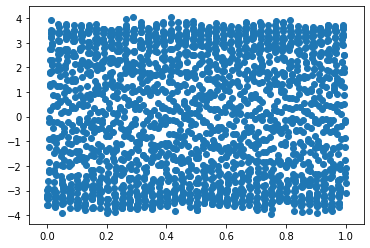

In [83]:
plt.scatter(xdata, ydata)

In [84]:
def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), 
                                                     full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
            error.append(np.absolute(pcov[i][i])**0.5)
        except:
            error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

pfit, perr = fit_leastsq(pstart, xdata, ydata, ff)

print("\n# Fit parameters and parameter errors from lestsq method :")
print("pfit = ", pfit)
print("perr = ", perr)


# Fit parameters and parameter errors from lestsq method :
pfit =  [39.99999371 -3.54206131  1.16661654]
perr =  [0.00104867 0.00914507 0.00040576]


In [85]:
def fit_curvefit(p0, datax, datay, function, yerr=[0.2 for item in xdata], **kwargs):
    """
    Note: As per the current documentation (Scipy V1.1.0), sigma (yerr) must be:
        None or M-length sequence or MxM array, optional
    Therefore, replace:
        err_stdev = 0.2
    With:
        err_stdev = [0.2 for item in xdata]
    Or similar, to create an M-length sequence for this example.
    """
    pfit, pcov = optimize.curve_fit(f,datax,datay,p0=p0,sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
            error.append(np.absolute(pcov[i][i])**0.5)
        except:
            error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit 

pfit, perr = fit_curvefit(pstart, xdata, ydata, ff)

print("\n# Fit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfit)
print("perr = ", perr)


# Fit parameters and parameter errors from curve_fit method :
pfit =  [39.99999371 -3.54206131  1.16661654]
perr =  [0.00104867 0.00914507 0.00040576]


In [87]:
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                             full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

pfit, perr = fit_bootstrap(pstart, xdata, ydata, ff)

print("\n# Fit parameters and parameter errors from bootstrap method :")
print("pfit = ", pfit)
print("perr = ", perr)


# Fit parameters and parameter errors from bootstrap method :
pfit =  [40.0010564  -3.54302321  1.16608177]
perr =  [0.0008951  0.00609164 0.00052972]


In [4]:
def sin(x: np.ndarray, amp: float, f: float, phase: float) -> np.ndarray:
    """
    Sinus function, used for fitting.

    :param x: Time axis
    :param amp: amplitude
    :param f: frequency
    :param phase: phase, normed to 1
    """
    return amp * np.sin(2. * np.pi * (f * x + phase))

def phases_simon(times, magnitudes, f_fix, a_guess, p_guess):
    
    freqs = []
    amps = []
    amps_err = []
    phases = []
    phases_err = []
    
    for i in range(len(f_fix)):

        model1 = Model(sin)
        #model1.set_param_hint('amp', value=a_guess[i], vary=False)
        model1.set_param_hint('amp', value=a_guess[i], min=0.5 * a_guess[i], max=1.5 * a_guess[i])
        model1.set_param_hint('f', value=f_fix[i], vary=False)
        model1.set_param_hint('phase', value=p_guess[i], min=0, max=1)
        result1 = model1.fit(magnitudes, x=times, method='least_squares')

        # after first fit, vary only phase
        model2 = Model(sin)
        model2.set_param_hint('amp', value=result1.values['amp'], vary=False)
        model2.set_param_hint('f', value=f_fix[i], vary=False)
        model2.set_param_hint('phase', value=result1.values['phase'], min=0, max=1)
        result2 = model2.fit(magnitudes, x=times, method='least_squares')

        freqs.append(result2.values['f'])
        amps.append(result2.values['amp'])
        amps_err.append(np.sqrt(np.diag(result1.covar)[0]))
        phases.append(result2.values['phase'])
        phases_err.append(np.sqrt(np.diag(result2.covar)[0]))
        
    freqs = np.array(freqs)
    amps = np.array(amps)
    amps_err = np.array(amps_err)
    phases = np.array(phases)
    phases_err = np.array(phases_err)

    return(freqs, amps, amps_err, phases, phases_err)

In [5]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

In [6]:
n = 25

sol1 = []
sol1_err = []
sol2 = []
sol2_err = []
sol3 = []
sol3_err = []
sol4 = []
sol4_err = []

right = []


def f( x, p1, p2):
    return abs(p1) * np.sin(2. * np.pi * (51.1 * x + (p2)%1))

def ff(x, p):
    return f(x, *p)

for i in range(n):
    # These are the true parameters
    #p0 = random.randrange(20, 80)
    p0 = 51.1
    p1 = random.random() * (10 - 1) + 1
    p2 = random.random()

    right.append([p1, p2])
    
    # These are initial guesses for fits:
    pstart = [
        #p0,
        p1 + random.random(), 
        random.random()
    ]

    print(p1)
    print(p2)
    
    xvals = np.linspace(0., 1, 4123)
    yvals = f(xvals, p1, p2)

    # Generate data with a bit of randomness
    # (the noise-less function that underlies the data is shown as a blue line)

    xdata = np.array(xvals)
    #np.random.seed(42)
    err_stdev = 0.8
    yvals_err =  np.random.normal(0., err_stdev, len(xdata))
    ydata = f(xdata, p1, p2) + yvals_err

    
    
    def fit_leastsq(p0, datax, datay, function):

        errfunc = lambda p, x, y: function(x,p) - y

        pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), 
                                                         full_output=1, epsfcn=0.0001)

        if (len(datay) > len(p0)) and pcov is not None:
            s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
            pcov = pcov * s_sq
        else:
            pcov = np.inf

        error = [] 
        for i in range(len(pfit)):
            try:
                error.append(np.absolute(pcov[i][i])**0.5)
            except:
                error.append( 0.00 )
        pfit_leastsq = pfit
        perr_leastsq = np.array(error) 
        return pfit_leastsq, perr_leastsq 

    pfit, perr = fit_leastsq(pstart, xdata, ydata, ff)

    sol1.append(pfit)
    sol1_err.append(perr)
    
    print("\n# Fit parameters and parameter errors from lestsq method :")
    print("pfit = ", pfit)
    print("perr = ", perr)

    def fit_curvefit(p0, datax, datay, function, yerr=[0.2 for item in xdata], **kwargs):
        """
        Note: As per the current documentation (Scipy V1.1.0), sigma (yerr) must be:
            None or M-length sequence or MxM array, optional
        Therefore, replace:
            err_stdev = 0.2
        With:
            err_stdev = [0.2 for item in xdata]
        Or similar, to create an M-length sequence for this example.
        """
        pfit, pcov = optimize.curve_fit(f,datax,datay,p0=p0,sigma=yerr, epsfcn=0.0001, **kwargs)
        error = [] 
        for i in range(len(pfit)):
            try:
                error.append(np.absolute(pcov[i][i])**0.5)
            except:
                error.append( 0.00 )
        pfit_curvefit = pfit
        perr_curvefit = np.array(error)
        return pfit_curvefit, perr_curvefit 

    pfit, perr = fit_curvefit(pstart, xdata, ydata, ff)

    sol2.append(pfit)
    sol2_err.append(perr)
    
    print("\n# Fit parameters and parameter errors from curve_fit method :")
    print("pfit = ", pfit)
    print("perr = ", perr)

    def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

        errfunc = lambda p, x, y: function(x,p) - y

        # Fit first time
        pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


        # Get the stdev of the residuals
        residuals = errfunc(pfit, datax, datay)
        sigma_res = np.std(residuals)

        sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

        # 100 random data sets are generated and fitted
        ps = []
        for i in range(100):

            randomDelta = np.random.normal(0., sigma_err_total, len(datay))
            randomdataY = datay + randomDelta

            randomfit, randomcov = \
                optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                                 full_output=0)

            ps.append(randomfit) 

        ps = np.array(ps)
        mean_pfit = np.mean(ps,0)

        # You can choose the confidence interval that you want for your
        # parameter estimates: 
        Nsigma = 1. # 1sigma gets approximately the same as methods above
                    # 1sigma corresponds to 68.3% confidence interval
                    # 2sigma corresponds to 95.44% confidence interval
        err_pfit = Nsigma * np.std(ps,0) 

        pfit_bootstrap = mean_pfit
        perr_bootstrap = err_pfit
        return pfit_bootstrap, perr_bootstrap 

    pfit, perr = fit_bootstrap(pstart, xdata, ydata, ff)
    
    sol3.append(pfit)
    sol3_err.append(perr)
    
    print("\n# Fit parameters and parameter errors from bootstrap method :")
    print("pfit = ", pfit)
    print("perr = ", perr)
    
    
    dft_phase(xdata, ydata, [p0])
    
    
    
    
    tmp = phases_simon(xdata, ydata, [p0], [p1], dft_phase(xdata, ydata, [p0])/(2*np.pi))
    sol4.append([tmp[1], tmp[3]])
    sol4_err.append([tmp[2], tmp[4]])

3.532080794085662
0.9419555481235846

# Fit parameters and parameter errors from lestsq method :
pfit =  [ 3.54130218 -0.05871486]
perr =  [0.01786333 0.00080121]

# Fit parameters and parameter errors from curve_fit method :
pfit =  [ 3.54130218 -0.05871486]
perr =  [0.01786333 0.00080121]

# Fit parameters and parameter errors from bootstrap method :
pfit =  [ 3.53860718 -0.0587552 ]
perr =  [0.01667009 0.00080047]
7.487516922645774
0.6212534197059065

# Fit parameters and parameter errors from lestsq method :
pfit =  [ 7.46303175 -0.37885682]
perr =  [0.01744546 0.00037247]

# Fit parameters and parameter errors from curve_fit method :
pfit =  [ 7.46303175 -0.37885682]
perr =  [0.01744546 0.00037247]

# Fit parameters and parameter errors from bootstrap method :
pfit =  [ 7.4657206  -0.37890404]
perr =  [0.0186341  0.00034128]
1.283504746497449
0.633968160517403

# Fit parameters and parameter errors from lestsq method :
pfit =  [1.27665682 0.63370958]
perr =  [0.01724665 0.00215303


# Fit parameters and parameter errors from bootstrap method :
pfit =  [4.17536592 0.67787805]
perr =  [0.01592391 0.0007343 ]
6.722486366466535
0.5629828304943962

# Fit parameters and parameter errors from lestsq method :
pfit =  [6.73046936 0.5628121 ]
perr =  [0.01781489 0.00042118]

# Fit parameters and parameter errors from curve_fit method :
pfit =  [6.73046936 0.5628121 ]
perr =  [0.01781489 0.00042118]

# Fit parameters and parameter errors from bootstrap method :
pfit =  [6.73095303 0.5627749 ]
perr =  [0.01798993 0.00041834]
6.703567957692144
0.5842201000528674

# Fit parameters and parameter errors from lestsq method :
pfit =  [-6.71008025  0.58428322]
perr =  [0.01759158 0.00041739]

# Fit parameters and parameter errors from curve_fit method :
pfit =  [-6.71008025  0.58428322]
perr =  [0.01759158 0.00041739]

# Fit parameters and parameter errors from bootstrap method :
pfit =  [-6.71220888  0.58431591]
perr =  [0.01628172 0.00040292]
3.80537589796306
0.8716343882853395



In [7]:
%matplotlib notebook

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

In [176]:
import matplotlib.pyplot as plt

In [178]:
%matplotlib inline

<IPython.core.display.Javascript object>


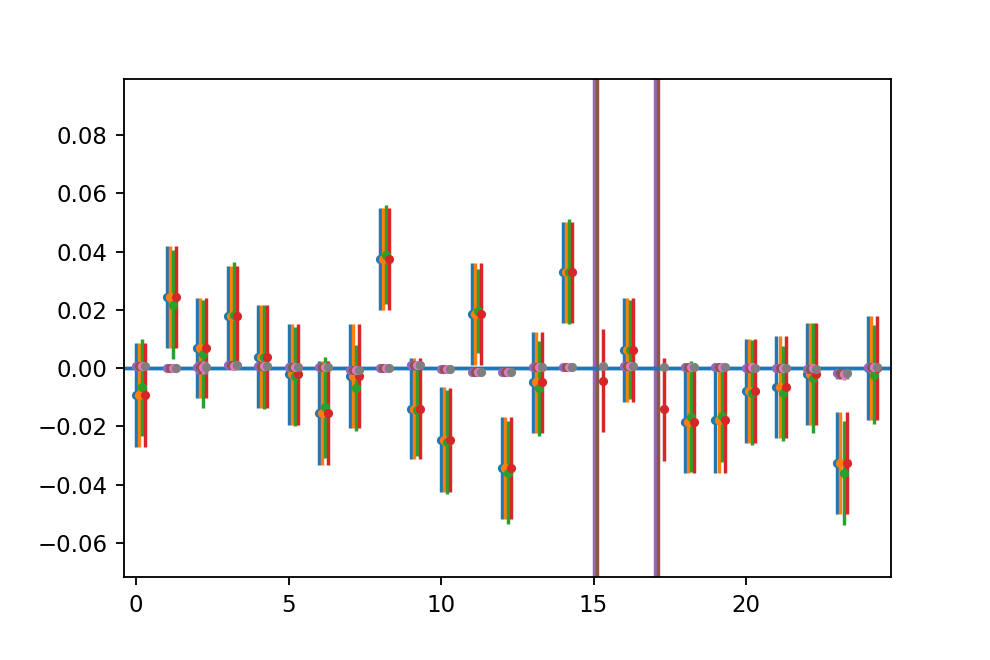

/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


<ErrorbarContainer object of 3 artists>

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.axhline(0)
ax.errorbar(range(n), [i[0] - abs(j[0]) for i,j in zip(right, sol1)], yerr = [i[0] for i in sol1_err], fmt='.')
ax.errorbar(np.arange(0,n)+0.1, [i[0] - abs(j[0]) for i,j in zip(right, sol2)], yerr = [i[0] for i in sol2_err], fmt='.')
ax.errorbar(np.arange(0,n)+0.2, [i[0] - abs(j[0]) for i,j in zip(right, sol3)], yerr = [i[0] for i in sol3_err], fmt='.')
ax.errorbar(np.arange(0,n)+0.3, [i[0] - abs(j[0]) for i,j in zip(right, sol4)], yerr = [i[0] for i in sol4_err], fmt='.')

<IPython.core.display.Javascript object>


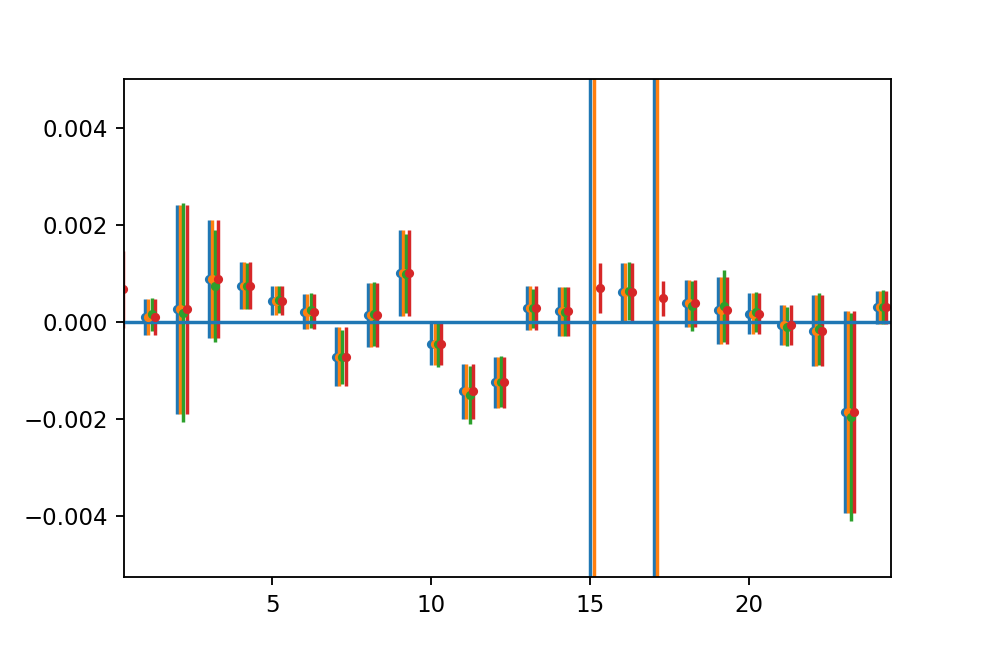

/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


<ErrorbarContainer object of 3 artists>

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.axhline(0)
ax.errorbar(range(n), [i[1] - j[1]%1 for i,j in zip(right, sol1)], yerr = [i[1] for i in sol1_err], fmt='.')
ax.errorbar(np.arange(n)+0.1, [i[1] - j[1]%1 for i,j in zip(right, sol2)], yerr = [i[1] for i in sol2_err], fmt='.')
ax.errorbar(np.arange(n)+0.2, [i[1] - j[1]%1 for i,j in zip(right, sol3)], yerr = [i[1] for i in sol3_err], fmt='.')
ax.errorbar(np.arange(n)+0.3, [i[1] - j[1]%1 for i,j in zip(right, sol4)], yerr = [i[1] for i in sol4_err], fmt='.')

In [17]:
def func1(val1):
    def func2(val2):
        return(val1*val2+val2)
    return func2

In [18]:
func1(5)(8)

48

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

from lmfit import Model

import scipy.special
import math

from astropy.io import fits

import random

from astropy.time import Time

In [29]:
%matplotlib inline

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


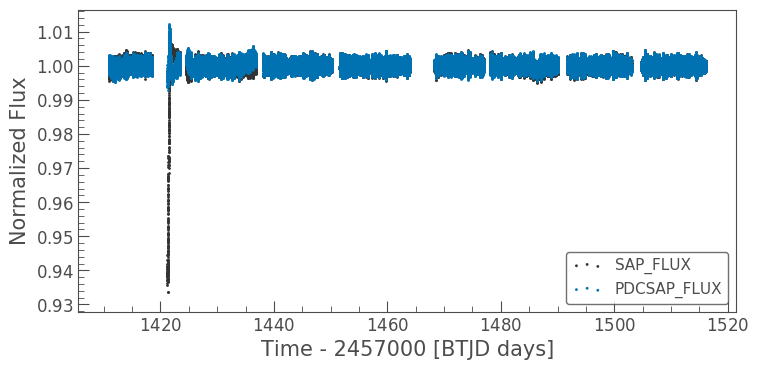

In [30]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [31]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [32]:
#Fourier Function
def fourier_sum(freqs, amps, phase, y_noise, x):
    y = []
    for j in range(0, len(x)):
        temp = []
        temp.append(y_noise[j])
        for i in range(0, len(freqs)):
            #next line: sum(amplitude_i * sine(freq_i * x + phase_i)) for all pulsations i 
            temp.append(amps[i]*np.sin(2.*np.pi*freqs[i]*x[j]+phase[i]))
        y.append(sum(temp))
    return y

def lc_sim(freqs, amps, phs, time_start, time_end, cadence, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time = np.arange(time_start, time_end, cadence)
    noise = np.random.normal(0, precision, len(time))
    
    multisine = np.array(fourier_sum(freqs, amps, phs, noise, time))

    return [freqs, amps, phs, time, multisine]

def lc_model(freqs, amps, phs, time_start, time_end, cadence_model):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = np.arange(time_start, time_end, cadence_model)
    noise_model = [0 for i in time_model]    

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = np.random.normal(0, precision, len(time_model))
    #noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

In [33]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

In [34]:
def sin(x: np.ndarray, amp: float, f: float, phase: float) -> np.ndarray:
    """
    Sinus function, used for fitting.

    :param x: Time axis
    :param amp: amplitude
    :param f: frequency
    :param phase: phase, normed to 1
    """
    return amp * np.sin(2. * np.pi * (f * x + phase))

def phases_simon(times, magnitudes, f_fix, a_guess, p_guess):
    
    freqs = []
    amps = []
    phases = []
    phases_err = []
    
    for i in range(len(f_fix)):

        model1 = Model(sin)
        #model1.set_param_hint('amp', value=a_guess[i], vary=False)
        model1.set_param_hint('amp', value=a_guess[i], min=0.5 * a_guess[i], max=1.5 * a_guess[i])
        model1.set_param_hint('f', value=f_fix[i], vary=False)
        model1.set_param_hint('phase', value=p_guess[i], min=0, max=1)
        result1 = model1.fit(magnitudes, x=times, method='least_squares')

        # after first fit, vary only phase
        model2 = Model(sin)
        model2.set_param_hint('amp', value=result1.values['amp'], vary=False)
        model2.set_param_hint('f', value=f_fix[i], vary=False)
        model2.set_param_hint('phase', value=result1.values['phase'], min=0, max=1)
        result2 = model2.fit(magnitudes, x=times, method='least_squares')

        freqs.append(result2.values['f'])
        amps.append(result2.values['amp'])
        phases.append(result2.values['phase'])
        phases_err.append(np.sqrt(np.diag(result2.covar)[0]))
        
    freqs = np.array(freqs)
    amps = np.array(amps)
    phases = np.array(phases)
    phases_err = np.array(phases_err)
        
    return(freqs, amps, phases, phases_err)

In [35]:
print('Calculate AS')
#AS
freq, amp = AS(times, mags, 15)

freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.02, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))


print('Calculate Phases')
# PHASES
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)



# SELECT HOW MANY FREQS FOR COMPARISON

n = 20

f_TESS = f_TESS[:20]
a_TESS = a_TESS[:20]
p_TESS = p_TESS[:20]

Calculate AS


82
Calculate Phases


In [36]:
f_TESS

array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
       46.5428208 , 48.91898731, 43.52777037, 47.28565013, 57.45201737,
       34.76022934, 38.12894767, 45.26948964, 53.85766147, 51.49607267,
       50.71711598, 47.13987304, 47.66403674, 49.71252171, 44.68384605])

In [37]:
import os
datadir = os.getcwd()
datafile = '/times_KIC_LC.txt'

times_KIC_load = np.loadtxt(datadir+datafile, usecols=(0)).T

times_KIC_LC = times_KIC_load

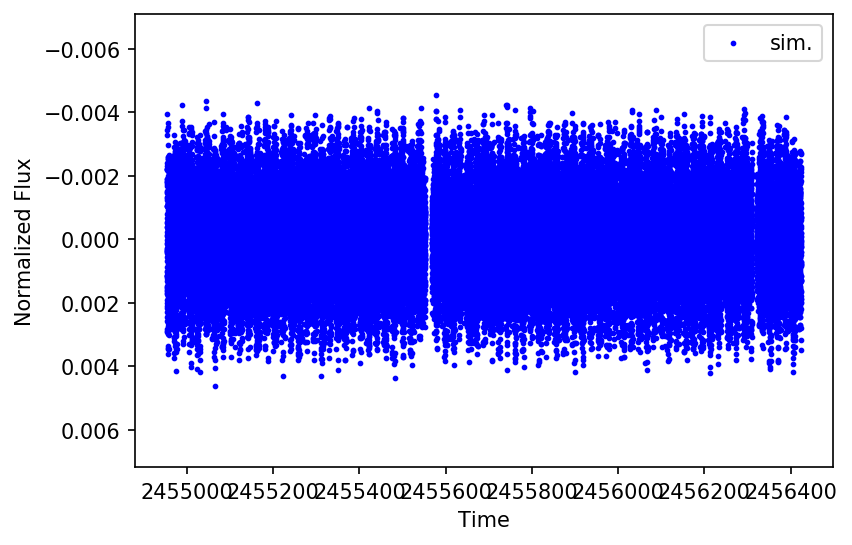

In [40]:
#Phases

f_TESS = f_TESS[:9]
a_TESS = a_TESS[:9]
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_KIC_LC, 0)

#Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(times_KIC_LC, model_times[4], s=3, c='b', label = 'sim.')

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Flux')
ax.legend()
ax.invert_yaxis()

#plt.savefig('posteriori.png')

(2455003, 2455004)

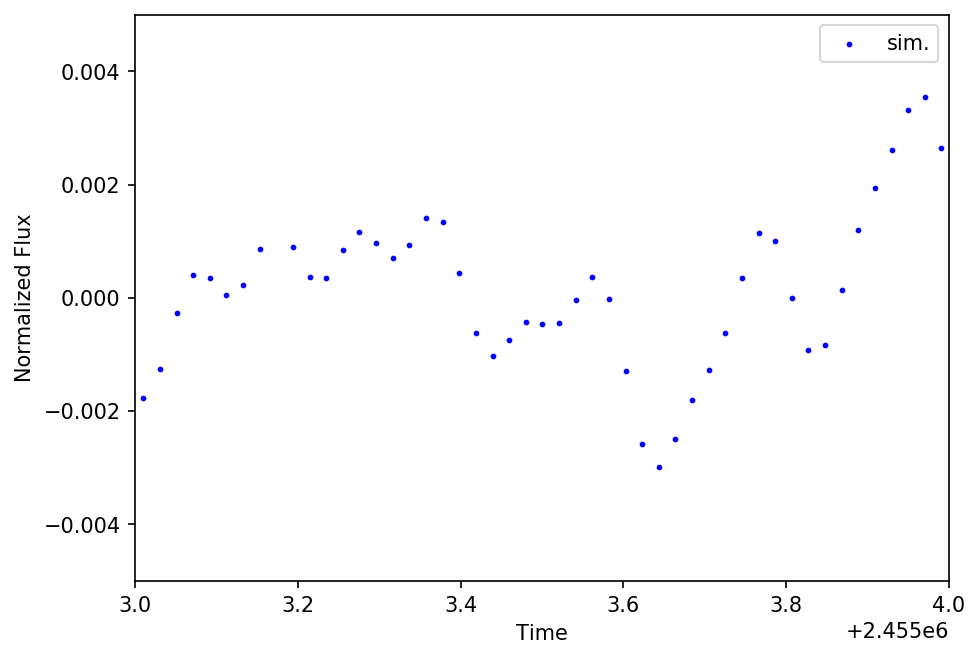

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.scatter(times_KIC_LC, model_times[4], s=3, c='b', label = 'sim.')

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Flux')
ax.legend()
ax.invert_yaxis()

ax.set_ylim(-0.005, 0.005)
ax.set_xlim(2455003, 2455004)

#plt.savefig('3oldLC1.png')

In [43]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

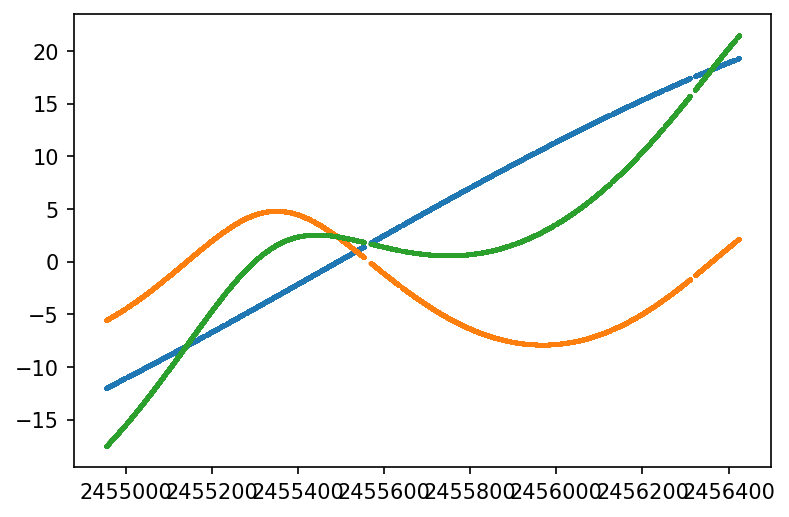

In [44]:
#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

y_tau_b = tau(times_KIC_LC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_vrad_b = vrad(times_KIC_LC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c = tau(times_KIC_LC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_vrad_c = vrad(times_KIC_LC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

plt.scatter(times_KIC_LC, (y_tau_b)*86400, s=1)
plt.scatter(times_KIC_LC, (y_tau_c)*86400, s=1)
plt.scatter(times_KIC_LC, (y_tau_b + y_tau_c)*86400, s=1)

In [45]:
#Amplitude Spectrum Function
def AS_TD(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(35, 60, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [49]:
jds = []
for i in np.arange(2009, 2015, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2009-01-01T12:00:00.000']
[2454833.]
['2010-01-01T12:00:00.000']
[2455198.]
['2011-01-01T12:00:00.000']
[2455563.]
['2012-01-01T12:00:00.000']
[2455928.]
['2013-01-01T12:00:00.000']
[2456294.]
['2014-01-01T12:00:00.000']
[2456659.]


In [95]:
segment_size = 50

times_TD = times_KIC_LC - y_tau_b - y_tau_c
magnitudes_TD = model_times[4]

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

counter = 1
size=int((max(times_TD)-min(times_TD))//segment_size)

# Iterate over lightcurve
for t, y in zip(times_TD, magnitudes_TD):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = phases_simon(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(sol)
        
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
        AS_data = AS_TD(time_slice, mag_slice, 3)
        freq_tmp = AS_data[0]
        amp_tmp = AS_data[1]
        ax.plot(freq_tmp, amp_tmp, c='k')
        ax.set_ylim(35,60)
        ax.set_ylim(0,0.0015)
        plt.savefig('AS_seg{0}'.format(counter))
        plt.close()
        
        time_0 = t
        time_slice, mag_slice = [], []

        t_edge.append(t)
        
        counter += 1
        
phase = np.array(phase).T
phase_err = np.array(phase_err).T

# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

1/29


2/29
3/29
4/29
5/29
6/29
7/29
8/29
9/29
10/29
11/29
12/29
13/29
14/29
15/29
16/29
17/29
18/29
19/29
20/29
21/29
22/29
23/29
24/29
25/29
26/29
27/29
28/29
29/29


In [96]:
td_weighted = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays)):
        #print(j)
        tds.append(time_delays[j][i])
        tds_err.append(time_delays_err[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
td_weighted = np.array(td_weighted) 

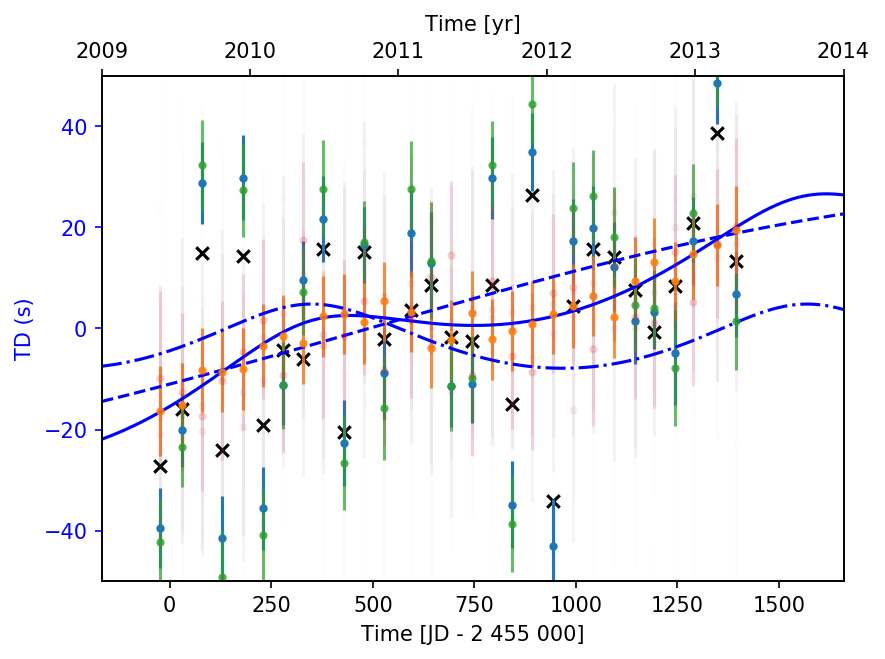

In [97]:
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
# y_vrad_c = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2455000

t_2009 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2011 = jds[2] - time_offset
t_2012 = jds[3] - time_offset
t_2013 = jds[4] - time_offset
t_2014 = jds[5] - time_offset

#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns1 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = "TD curve")
ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', label = "TD curve", ls = '--')
ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', label = "TD curve", ls = '-.')
ax1.set_xlabel('Time [JD - 2 455 000]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-50, 50)
ax1.set_xlim(t_2009, t_2014)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)





ax2.set_xticks([t_2009,t_2010,t_2011,t_2012,t_2013,t_2014])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2009', '2010', '2011', '2012', '2013', '2014'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')




y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_offset = np.mean((y_tau_b_sim + y_tau_c_sim) *86400 - td_weighted*86400)
ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   

for i in range(9):
    ax1.errorbar(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, yerr = time_delays_err[i]*86400, fmt='.', alpha = (a_TESS[i]/a_TESS[0])**3)
    #ax1.scatter(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, alpha = (a_TESS[i]/a_TESS[0])**3, s=5)




# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)





fig.tight_layout()
plt.show()

fig.savefig("TD_Kepler2_LC-3211.png", dpi=400)

# LEASTSQ

In [85]:
def fit_leastsq_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
    
        def fit_leastsq(p0, datax, datay, function):

            errfunc = lambda p, x, y: function(x,p) - y

            pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

            if (len(datay) > len(p0)) and pcov is not None:
                s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
                pcov = pcov * s_sq
            else:
                pcov = np.inf

            error = [] 
            for i in range(len(pfit)):
                try:
                    error.append(np.absolute(pcov[i][i])**0.5)
                except:
                    error.append( 0.00 )
            pfit_leastsq = pfit
            perr_leastsq = np.array(error) 
            return pfit_leastsq, perr_leastsq 

        pfit, perr = fit_leastsq(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

In [88]:
fit_leastsq_my(times, mags, f_TESS, a_TESS, p_TESS)

(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
        46.5428208 , 48.91898731, 43.52777037, 47.28565013]),
 array([0.00104251, 0.0009682 , 0.00093129, 0.00056303, 0.00043959,
        0.00041055, 0.00023213, 0.00020785, 0.00016282]),
 array([0.75189884, 0.3726177 , 0.19597371, 0.83284391, 0.1421943 ,
        0.33119305, 0.45986463, 0.97939882, 0.39643206]),
 array([0.00115571, 0.00126899, 0.00133109, 0.00235224, 0.00305165,
        0.00327774, 0.00586986, 0.00656134, 0.00838276]))

In [149]:
segment_size = 50

times_TD = times_KIC_LC - y_tau_b - y_tau_c
magnitudes_TD = model_times[4]

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

counter = 1
size=int((max(times_TD)-min(times_TD))//segment_size)

# Iterate over lightcurve
for t, y in zip(times_TD, magnitudes_TD):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(sol)
        
        
        #print(phase_guess)
        phase.append(sol[2]*2*np.pi)
        phase_err.append(sol[3]*2*np.pi)
        
#         fig, ax = plt.subplots(1, 1, figsize=(7, 4))
#         AS_data = AS_TD(time_slice, mag_slice, 3)
#         freq_tmp = AS_data[0]
#         amp_tmp = AS_data[1]
#         ax.plot(freq_tmp, amp_tmp, c='k')
#         ax.set_ylim(35,60)
#         ax.set_ylim(0,0.0015)
#         plt.savefig('AS_seg{0}'.format(counter))
#         plt.close()
        
        time_0 = t
        time_slice, mag_slice = [], []

        t_edge.append(t)
        
        counter += 1
        
phase = np.array(phase).T
phase_err = np.array(phase_err).T

# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

1/29
2/29
3/29
4/29
5/29
6/29
7/29
8/29
9/29
10/29
11/29
12/29
13/29
14/29
15/29
16/29
17/29
18/29
19/29
20/29
21/29
22/29
23/29
24/29
25/29
26/29
27/29
28/29
29/29


In [150]:
td_weighted = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays)):
        #print(j)
        tds.append(time_delays[j][i])
        tds_err.append(time_delays_err[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
td_weighted = np.array(td_weighted) 

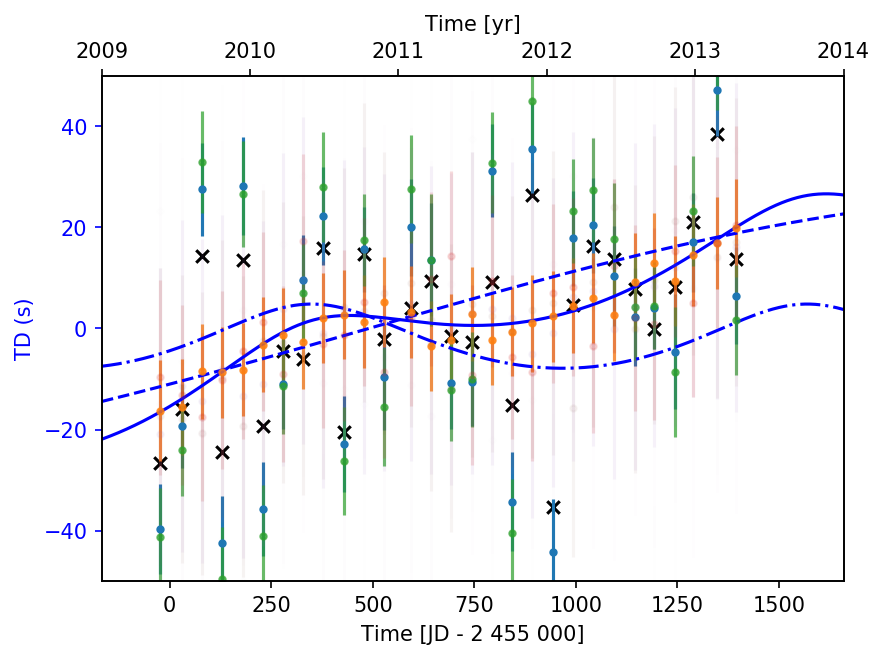

In [151]:
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
# y_vrad_c = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2455000

t_2009 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2011 = jds[2] - time_offset
t_2012 = jds[3] - time_offset
t_2013 = jds[4] - time_offset
t_2014 = jds[5] - time_offset

#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns1 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = "TD curve")
ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', label = "TD curve", ls = '--')
ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', label = "TD curve", ls = '-.')
ax1.set_xlabel('Time [JD - 2 455 000]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-50, 50)
ax1.set_xlim(t_2009, t_2014)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)





ax2.set_xticks([t_2009,t_2010,t_2011,t_2012,t_2013,t_2014])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2009', '2010', '2011', '2012', '2013', '2014'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')




y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_offset = np.mean((y_tau_b_sim + y_tau_c_sim) *86400 - td_weighted*86400)
ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   

for i in range(9):
    ax1.errorbar(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, yerr = time_delays_err[i]*86400, fmt='.', alpha = (a_TESS[i]/a_TESS[0])**3)
    #ax1.scatter(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, alpha = (a_TESS[i]/a_TESS[0])**3, s=5)




# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)





fig.tight_layout()
plt.show()

fig.savefig("TD_Kepler2_LC-3212.png", dpi=400)

# LEASTSQ

In [152]:
def fit_curvefit_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        tmp=model_new(freqs[i])
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
        
        
        def fit_curvefit(p0, datax, datay, function, yerr=[0.2 for item in times], **kwargs):
            """
            Note: As per the current documentation (Scipy V1.1.0), sigma (yerr) must be:
                None or M-length sequence or MxM array, optional
            Therefore, replace:
                err_stdev = 0.2
            With:
                err_stdev = [0.2 for item in xdata]
            Or similar, to create an M-length sequence for this example.
            """
            pfit, pcov = optimize.curve_fit(tmp,datax,datay,p0=p0,sigma=yerr, epsfcn=0.0001, **kwargs)
            error = [] 
            for i in range(len(pfit)):
                try:
                    error.append(np.absolute(pcov[i][i])**0.5)
                except:
                    error.append( 0.00 )
            pfit_curvefit = pfit
            perr_curvefit = np.array(error)
            return pfit_curvefit, perr_curvefit 
        
        
        pfit, perr = fit_curvefit(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

In [153]:
fit_curvefit_my(times, mags, f_TESS, a_TESS, p_TESS)

(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
        46.5428208 , 48.91898731, 43.52777037, 47.28565013]),
 array([0.00104251, 0.0009682 , 0.00093129, 0.00056303, 0.00043959,
        0.00041055, 0.00023213, 0.00020785, 0.00016282]),
 array([0.75189884, 0.3726177 , 0.19597371, 0.83284391, 0.1421943 ,
        0.33119305, 0.45986463, 0.97939882, 0.39643206]),
 array([0.00115571, 0.00126899, 0.00133109, 0.00235224, 0.00305165,
        0.00327774, 0.00586986, 0.00656134, 0.00838276]))

In [154]:
segment_size = 50

times_TD = times_KIC_LC - y_tau_b - y_tau_c
magnitudes_TD = model_times[4]

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

counter = 1
size=int((max(times_TD)-min(times_TD))//segment_size)

# Iterate over lightcurve
for t, y in zip(times_TD, magnitudes_TD):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_curvefit_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(sol)
        
        
        #print(phase_guess)
        phase.append(sol[2]*2*np.pi)
        phase_err.append(sol[3]*2*np.pi)
        
#         fig, ax = plt.subplots(1, 1, figsize=(7, 4))
#         AS_data = AS_TD(time_slice, mag_slice, 3)
#         freq_tmp = AS_data[0]
#         amp_tmp = AS_data[1]
#         ax.plot(freq_tmp, amp_tmp, c='k')
#         ax.set_ylim(35,60)
#         ax.set_ylim(0,0.0015)
#         plt.savefig('AS_seg{0}'.format(counter))
#         plt.close()
        
        time_0 = t
        time_slice, mag_slice = [], []

        t_edge.append(t)
        
        counter += 1
        
phase = np.array(phase).T
phase_err = np.array(phase_err).T

# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

1/29
2/29
3/29
4/29
5/29
6/29
7/29
8/29
9/29
10/29
11/29
12/29
13/29
14/29
15/29
16/29
17/29
18/29
19/29
20/29
21/29
22/29
23/29
24/29
25/29
26/29
27/29
28/29
29/29


In [155]:
td_weighted = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays)):
        #print(j)
        tds.append(time_delays[j][i])
        tds_err.append(time_delays_err[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
td_weighted = np.array(td_weighted) 

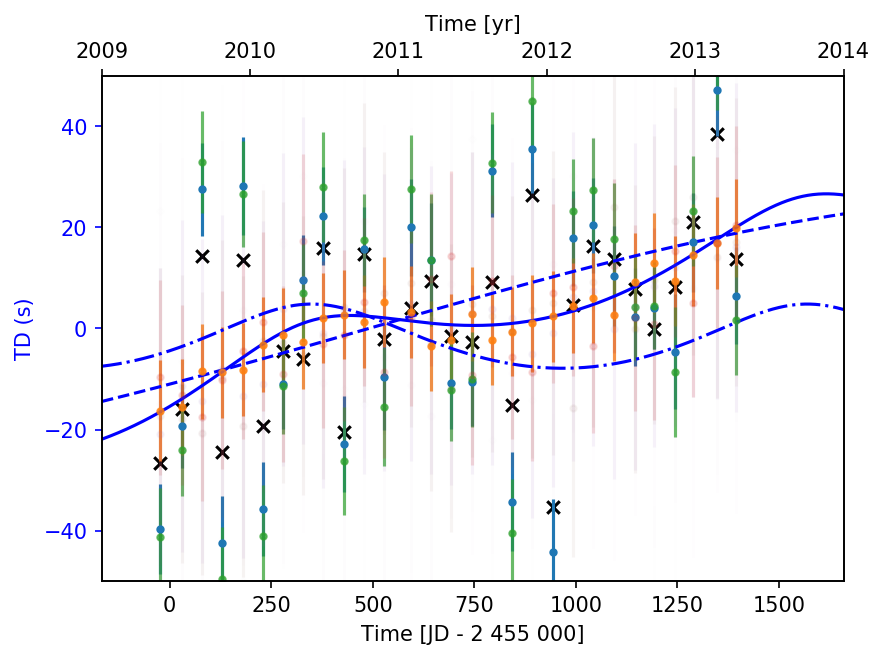

In [156]:
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
# y_vrad_c = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2455000

t_2009 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2011 = jds[2] - time_offset
t_2012 = jds[3] - time_offset
t_2013 = jds[4] - time_offset
t_2014 = jds[5] - time_offset

#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns1 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = "TD curve")
ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', label = "TD curve", ls = '--')
ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', label = "TD curve", ls = '-.')
ax1.set_xlabel('Time [JD - 2 455 000]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-50, 50)
ax1.set_xlim(t_2009, t_2014)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)





ax2.set_xticks([t_2009,t_2010,t_2011,t_2012,t_2013,t_2014])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2009', '2010', '2011', '2012', '2013', '2014'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')




y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_offset = np.mean((y_tau_b_sim + y_tau_c_sim) *86400 - td_weighted*86400)
ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   

for i in range(9):
    ax1.errorbar(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, yerr = time_delays_err[i]*86400, fmt='.', alpha = (a_TESS[i]/a_TESS[0])**3)
    #ax1.scatter(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, alpha = (a_TESS[i]/a_TESS[0])**3, s=5)




# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)





fig.tight_layout()
plt.show()

fig.savefig("TD_Kepler2_LC-3213.png", dpi=400)

# BOOTSTRAP

In [157]:
def fit_bootstrap_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        tmp=model_new(freqs[i])
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
        
        
        def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

            errfunc = lambda p, x, y: function(x,p) - y

            # Fit first time
            pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


            # Get the stdev of the residuals
            residuals = errfunc(pfit, datax, datay)
            sigma_res = np.std(residuals)

            sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

            # 100 random data sets are generated and fitted
            ps = []
            for i in range(100):

                randomDelta = np.random.normal(0., sigma_err_total, len(datay))
                randomdataY = datay + randomDelta

                randomfit, randomcov = \
                    optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                                     full_output=0)

                ps.append(randomfit) 

            ps = np.array(ps)
            mean_pfit = np.mean(ps,0)

            # You can choose the confidence interval that you want for your
            # parameter estimates: 
            Nsigma = 1. # 1sigma gets approximately the same as methods above
                        # 1sigma corresponds to 68.3% confidence interval
                        # 2sigma corresponds to 95.44% confidence interval
            err_pfit = Nsigma * np.std(ps,0) 

            pfit_bootstrap = mean_pfit
            perr_bootstrap = err_pfit
            return pfit_bootstrap, perr_bootstrap 
        
        
        pfit, perr = fit_bootstrap(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

In [120]:
fit_bootstrap_my(times, mags, f_TESS, a_TESS, p_TESS)

(array([47.43903298, 53.69160236, 50.49211222, 54.23794952, 39.06318864,
        46.5428208 , 48.91898731, 43.52777037, 47.28565013]),
 array([0.00104371, 0.00096872, 0.0009305 , 0.0005624 , 0.00043921,
        0.00041188, 0.00023128, 0.00020833, 0.00016358]),
 array([0.75198474, 0.37261622, 0.19580682, 0.83249085, 0.14218383,
        0.33119154, 0.46015399, 0.97769829, 0.39795622]),
 array([1.20010716e-03, 5.55111512e-17, 2.97033674e-04, 1.80909338e-03,
        1.11022302e-16, 1.11022302e-16, 2.70639403e-03, 5.59166366e-03,
        4.55803935e-03]))

In [158]:
segment_size = 50

times_TD = times_KIC_LC - y_tau_b - y_tau_c
magnitudes_TD = model_times[4]

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []

t_edge = []

counter = 1
size=int((max(times_TD)-min(times_TD))//segment_size)

# Iterate over lightcurve
for t, y in zip(times_TD, magnitudes_TD):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_bootstrap_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(sol)
        
        
        #print(phase_guess)
        phase.append(sol[2]*2*np.pi)
        phase_err.append(sol[3]*2*np.pi)
        
#         fig, ax = plt.subplots(1, 1, figsize=(7, 4))
#         AS_data = AS_TD(time_slice, mag_slice, 3)
#         freq_tmp = AS_data[0]
#         amp_tmp = AS_data[1]
#         ax.plot(freq_tmp, amp_tmp, c='k')
#         ax.set_ylim(35,60)
#         ax.set_ylim(0,0.0015)
#         plt.savefig('AS_seg{0}'.format(counter))
#         plt.close()
        
        time_0 = t
        time_slice, mag_slice = [], []

        t_edge.append(t)
        
        counter += 1
        
phase = np.array(phase).T
phase_err = np.array(phase_err).T

# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

1/29
2/29
3/29
4/29
5/29
6/29
7/29
8/29
9/29
10/29
11/29
12/29
13/29
14/29
15/29
16/29
17/29
18/29
19/29
20/29
21/29
22/29
23/29
24/29
25/29
26/29
27/29
28/29
29/29


In [159]:
td_weighted = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays)):
        #print(j)
        tds.append(time_delays[j][i])
        tds_err.append(time_delays_err[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
td_weighted = np.array(td_weighted) 

/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/sebastian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


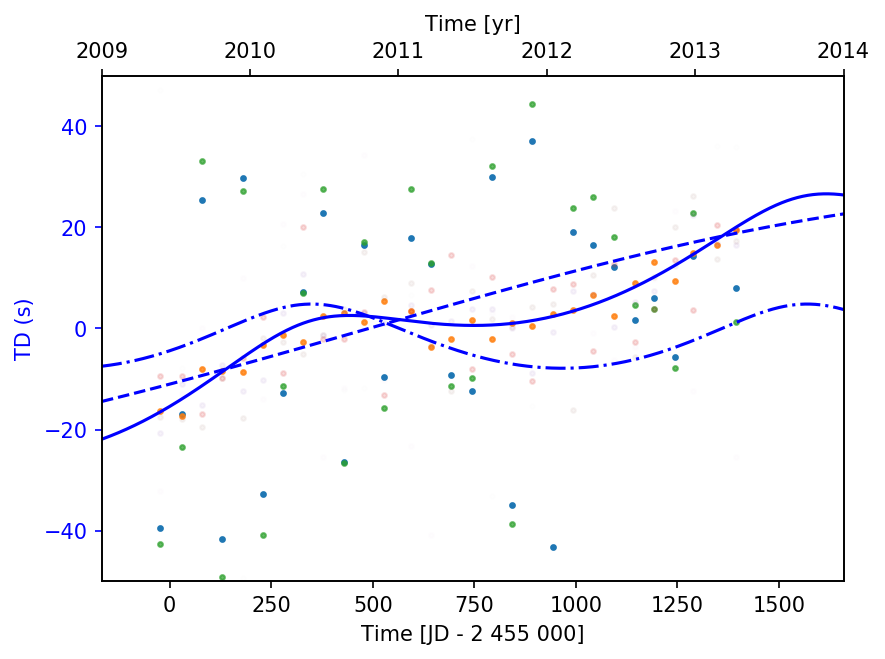

In [161]:
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
# y_vrad_c = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4.5))

time_offset = 2455000

t_2009 = jds[0] - time_offset
t_2010 = jds[1] - time_offset
t_2011 = jds[2] - time_offset
t_2012 = jds[3] - time_offset
t_2013 = jds[4] - time_offset
t_2014 = jds[5] - time_offset

#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns1 = ax1.plot(times_sim - time_offset, (y_tau_b_sim + y_tau_c_sim) *86400, 'b', label = "TD curve")
ax1.plot(times_sim - time_offset, (y_tau_b_sim) *86400, 'b', label = "TD curve", ls = '--')
ax1.plot(times_sim - time_offset, (y_tau_c_sim) *86400, 'b', label = "TD curve", ls = '-.')
ax1.set_xlabel('Time [JD - 2 455 000]')

ax1.set_ylabel('TD (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-50, 50)
ax1.set_xlim(t_2009, t_2014)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)





ax2.set_xticks([t_2009,t_2010,t_2011,t_2012,t_2013,t_2014])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2009', '2010', '2011', '2012', '2013', '2014'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')




y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_offset = np.mean((y_tau_b_sim + y_tau_c_sim) *86400 - td_weighted*86400)
#ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   

for i in range(9):
    #ax1.errorbar(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, yerr = time_delays_err[i]*86400, fmt='.', alpha = (a_TESS[i]/a_TESS[0])**3)
    ax1.scatter(np.array(time_midpoints) - time_offset, time_delays[i]*86400+1.5, alpha = (a_TESS[i]/a_TESS[0])**3, s=5)


# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)





fig.tight_layout()
plt.show()

fig.savefig("TD_Kepler2_LC-3214.png", dpi=400)

In [162]:
lk.search()

<module 'lightkurve' from '/home/sebastian/anaconda3/lib/python3.7/site-packages/lightkurve/__init__.py'>

(-2000, 2000)

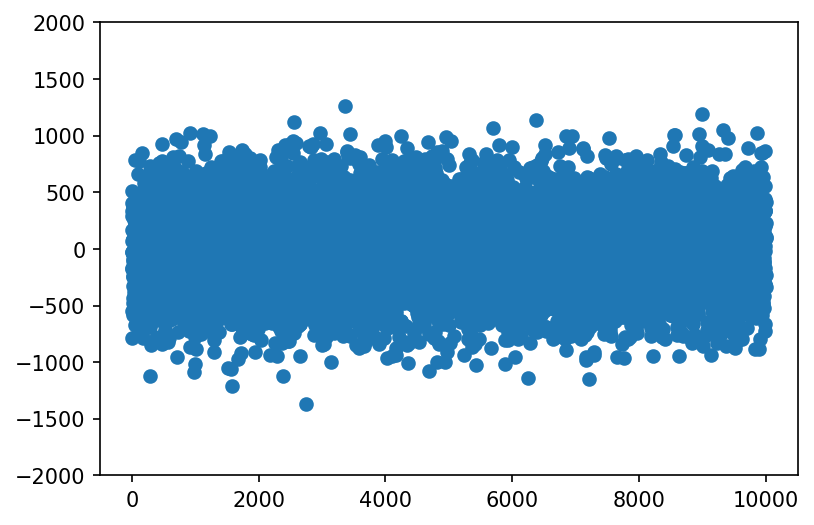

In [10]:
def rms(array):
    array = np.array(array)
    tmp = np.sqrt(np.mean((array-np.mean(array))**2))
    return tmp

def rms2(array):
    array = np.array(array)
    tmp = np.sqrt(np.mean((array)**2))
    return tmp

In [99]:
from astropy.stats import LombScargle
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(0, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp, power))

In [278]:
m_tmp = []

len_tmp = []

for j in np.arange(25,1000,133):

    noise_lk_list = []

    rms_calc = []
    rms_calc2 = []

    for i in np.arange(1,10000, 655):

        noise_lk = i*1e-6
        noise_lk_list.append(noise_lk)

        t_lk = np.arange(1440, 1440+j, 1/24)
        
        
        
        f_lk = np.random.normal(0,noise_lk ,len(t_lk))+1
        f_lk_sin = (f_lk + 0.001*np.sin(2*np.pi*50*t_lk))
        f_lk_sin = f_lk_sin/np.median(f_lk_sin)

        as_lk = AS(t_lk, f_lk_sin, 10)
        lc_lk = lk.LightCurve(t_lk, f_lk)


        #half = int(len(t_lk)/2)
        rms_calc.append(rms(f_lk))
        rms_calc2.append(rms(as_lk[1][100:]))

    len_tmp.append(len(t_lk))
    m,b = np.polyfit(noise_lk_list, rms_calc2, 1)
    #x_bla = np.linspace(0, 0.1, 1000)
    #y_bla = m*x_bla+b

    m_tmp.append(m)
    
m_tmp = np.array(m_tmp)

/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: divide by zero encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)
/home/sebastian/anaconda3/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:122: RuntimeWarning: invalid value encountered in true_divide
  power = (YC * YC / CC + YS * YS / SS)


In [219]:
len_tmp

[600, 1392, 2184, 2976, 3768, 4560, 5352, 6144, 6936, 7728, 8520, 9312]

In [220]:
m_tmp

array([0.03787235, 0.02474828, 0.02038281, 0.0169563 , 0.0152792 ,
       0.01386385, 0.01265822, 0.011798  , 0.01112704, 0.01050719,
       0.00999042, 0.00954195])

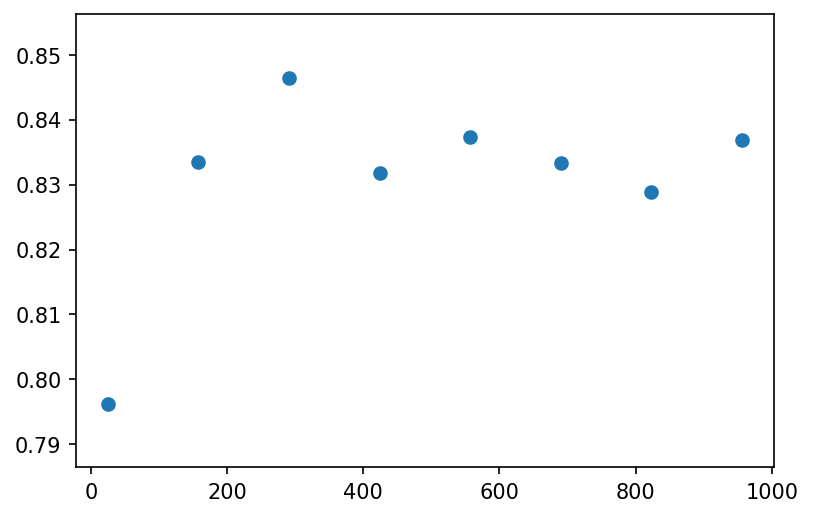

In [283]:
plt.scatter(np.arange(25,1000,133), np.sqrt(len_tmp)*m_tmp)

#plt.plot([0,1000], [0,1000])

#plt.ylim(0,1000)
#plt.xlim(0, 400)

In [ ]:
m_tmp = []

len_tmp = []

for j in np.arange(25,1000,133):

    noise_lk_list = []

    rms_calc = []
    rms_calc2 = []

    for i in np.arange(1,10000, 655):

        noise_lk = i*1e-6
        noise_lk_list.append(noise_lk)

        t_lk = np.arange(1440, 1440+j, 1/24)
        
        
        
        f_lk = np.random.normal(0,noise_lk ,len(t_lk))+1
        f_lk_sin = (f_lk + 0.001*np.sin(2*np.pi*50*t_lk))
        f_lk_sin = f_lk_sin/np.median(f_lk_sin)

        as_lk = AS(t_lk, f_lk_sin, 10)
        lc_lk = lk.LightCurve(t_lk, f_lk)


        #half = int(len(t_lk)/2)
        rms_calc.append(rms(f_lk))
        rms_calc2.append(rms(as_lk[1][100:]))

    len_tmp.append(len(t_lk))
    m,b = np.polyfit(noise_lk_list, rms_calc2, 1)
    #x_bla = np.linspace(0, 0.1, 1000)
    #y_bla = m*x_bla+b

    m_tmp.append(m)
    
m_tmp = np.array(m_tmp)

(0, 400)

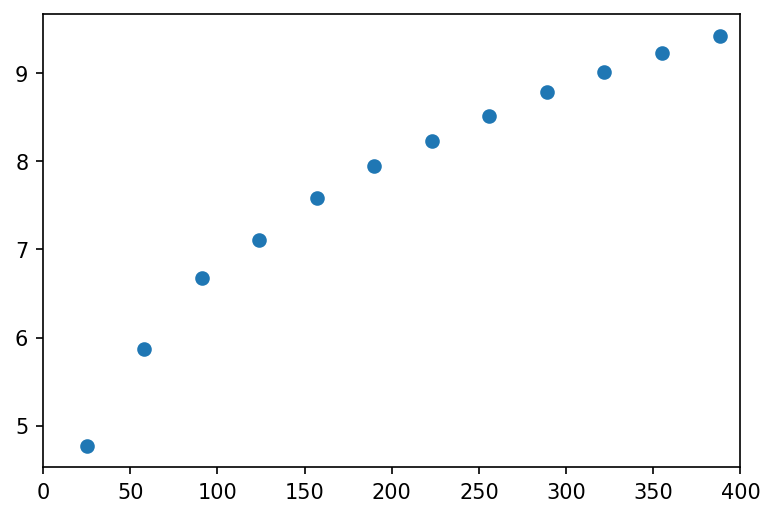

In [223]:
plt.scatter(np.arange(25,400,33), np.sqrt(np.array([a*b for a,b in zip(len_tmp,m_tmp)])))

plt.xlim(0, 400)


In [277]:
noise_lk = 1
noise_lk_list.append(noise_lk)

t_lk = np.arange(1440, 1440+100, 1/24)

f_lk = np.random.normal(0,noise_lk ,len(t_lk))+1
f_lk_sin = f_lk#(f_lk + 0.001*np.sin(2*np.pi*50*t_lk))
f_lk_sin = f_lk_sin/np.median(f_lk_sin)

as_lk = AS(t_lk, f_lk_sin, 10)
lc_lk = lk.LightCurve(t_lk, f_lk)


print(rms(f_lk))
print(rms(as_lk[1][100:]))
print(rms(as_lk[1][100:])*np.sqrt(len(t_lk)))

1.0183826186790457
0.01946849948962003
0.953757796144076


In [ ]:
plt.scatter(noise_lk_list, rms_calc2)

plt.plot(x_bla, y_bla)

plt.xlim(0, max(noise_lk_list))
plt.ylim(0, max(rms_calc2))

(0, 0.009933596554250957)

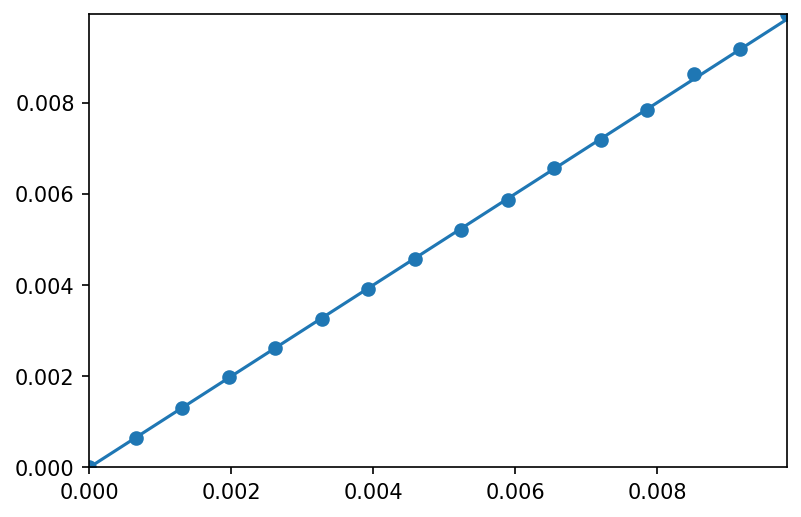

In [168]:
plt.scatter(noise_lk_list, rms_calc)

plt.plot([0,1], [0,1])

plt.xlim(0, max(noise_lk_list))
plt.ylim(0, max(rms_calc))


(0, 6.636526989992086e-05)

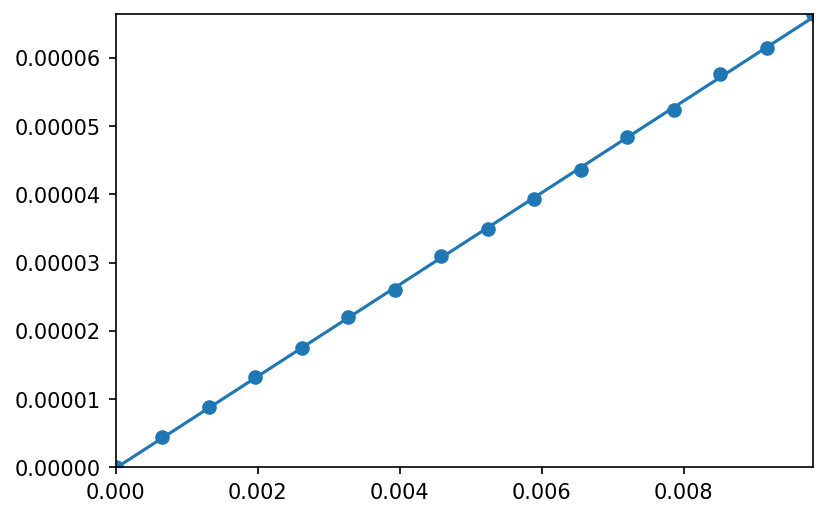

In [169]:
m,b = np.polyfit(noise_lk_list, rms_calc2, 1)
x_bla = np.linspace(0, 0.1, 1000)
y_bla = m*x_bla+b

plt.scatter(noise_lk_list, rms_calc2)

plt.plot(x_bla, y_bla)

plt.xlim(0, max(noise_lk_list))
plt.ylim(0, max(rms_calc2))

In [154]:
b

-1.614787944704616e-07

In [155]:
m

0.013454265154099915

In [159]:
b

-1.1403792492981107e-08

In [160]:
m

0.009433359544018804

In [164]:
b

-1.1172212035694179e-07

In [165]:
m

0.007783932207060682

In [166]:
np.sqrt(2)*0.0094333

0.013340700797934119

In [170]:
b

-9.350593100170376e-08

In [171]:
m

0.006723127501315915

In [172]:
np.sqrt(2)*m

0.009507938093924506

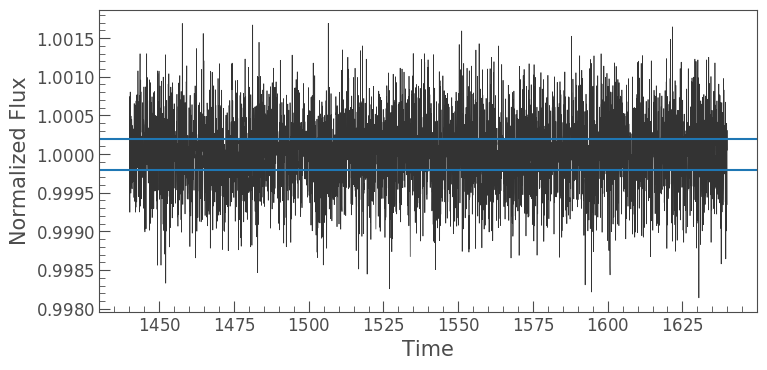

In [96]:
lc_lk.plot()
plt.axhline(1+20*10e-6)
plt.axhline(1-20*10e-6)

In [97]:
np.sqrt(sum(as_lk[2][1:]*4*len(t_lk)))

58.91484260645384

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


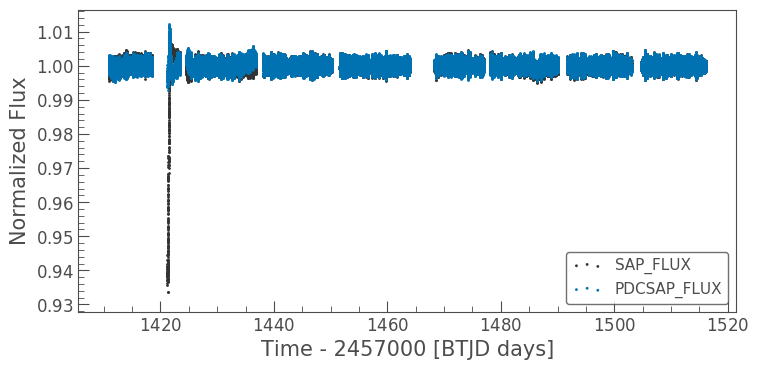

In [756]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = lc1.flux#-2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [4]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 360, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp, power))

In [758]:
freq_tmp, amp_tmp, power_tmp = AS(times, mags, 20)

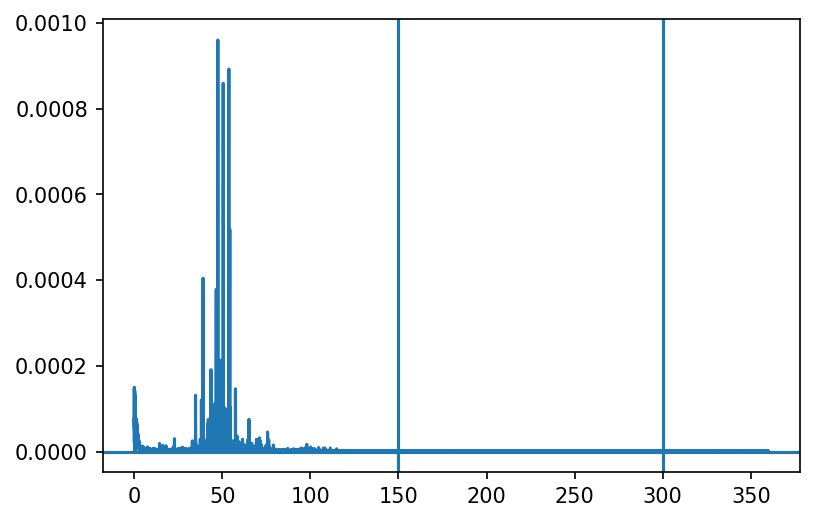

In [759]:
plt.plot(freq_tmp, amp_tmp)
#plt.xlim(120, 360)
#plt.ylim(0, 0.00001)
plt.axvline(150)
plt.axvline(300)
plt.axhline()

In [763]:
121.2868/np.sqrt(30)

22.143838762539193

In [760]:
np.mean(amp_tmp[378650:])/np.sqrt(np.pi/len(times))*1e6

121.28680175845162

In [761]:
np.median(amp_tmp[378650:])/np.sqrt(np.pi/len(times))*1e6

113.83951058641756

In [762]:
2*rms(amp_tmp[378650:])/np.sqrt(np.pi/len(times))*1e6

126.69571401526441

SearchResult containing 12 data products.

 target_name            productFilename                        description              distance
------------- ------------------------------------ ------------------------------------ --------
kplr003429637 kplr003429637-2010296114515_slc.fits  Lightcurve Short Cadence (CSC) - Q7      0.0
kplr003429637 kplr003429637-2010326094124_slc.fits  Lightcurve Short Cadence (CSC) - Q7      0.0
kplr003429637 kplr003429637-2010355172524_slc.fits  Lightcurve Short Cadence (CSC) - Q7      0.0
kplr003429637 kplr003429637-2011024051157_slc.fits  Lightcurve Short Cadence (CSC) - Q8      0.0
kplr003429637 kplr003429637-2011053090032_slc.fits  Lightcurve Short Cadence (CSC) - Q8      0.0
kplr003429637 kplr003429637-2011073133259_slc.fits  Lightcurve Short Cadence (CSC) - Q8      0.0
kplr003429637 kplr003429637-2011116030358_slc.fits  Lightcurve Short Cadence (CSC) - Q9      0.0
kplr003429637 kplr003429637-2011145075126_slc.fits  Lightcurve Short Cadence (CSC) -

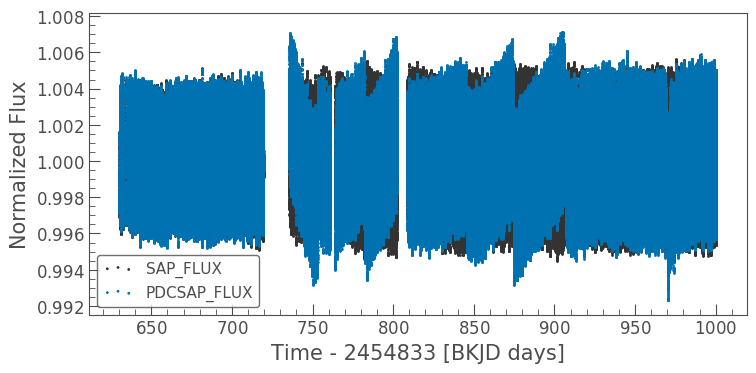

In [766]:
for name in ['KIC 3429637']:
    sr = lk.search_lightcurvefile(name, mission='Kepler', cadence='short')
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = lc1.flux#-2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [5]:
freq_tmp, amp_tmp, power_tmp = AS(times, mags, 10)

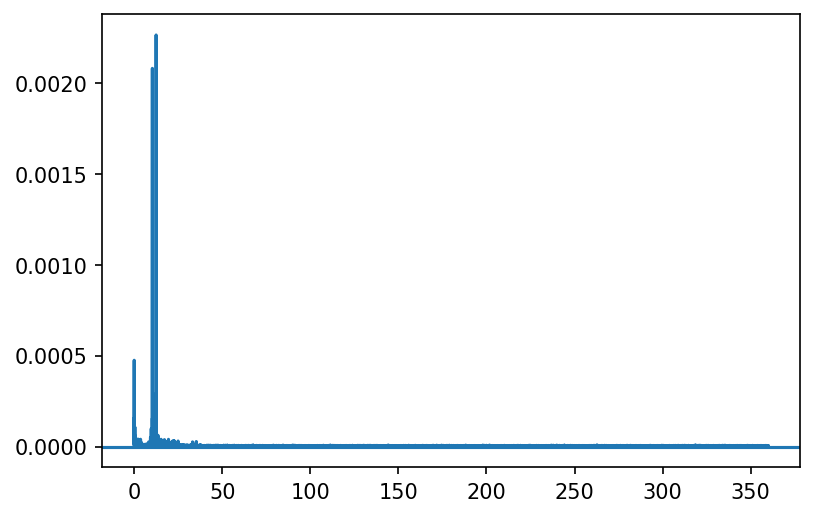

In [768]:
plt.plot(freq_tmp, amp_tmp)
#plt.xlim(120, 360)
#plt.ylim(0, 0.00001)

plt.axhline()

In [770]:
len(amp_tmp)/2

666199.0

In [771]:
np.mean(amp_tmp[666199:])/np.sqrt(np.pi/len(times))*1e6

894.2824068658123

In [772]:
np.median(amp_tmp[666199:])/np.sqrt(np.pi/len(times))*1e6

840.3905790683243

In [773]:
2*rms(amp_tmp[666199:])/np.sqrt(np.pi/len(times))*1e6

934.0863688075891

In [774]:
894.2/np.sqrt(60)

115.44072360595574

SearchResult containing 23 data products.

 target_name            productFilename                        description              distance
------------- ------------------------------------ ------------------------------------ --------
kplr100002729 kplr100002729-2010203174610_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr100002733 kplr100002733-2010234115140_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr100002737 kplr100002737-2010265121752_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr100003414 kplr100003414-2011024051157_slc.fits  Lightcurve Short Cadence (CSC) - Q8      0.0
kplr100003414 kplr100003414-2013017113907_slc.fits Lightcurve Short Cadence (CSC) - Q16      0.0
kplr100003414 kplr100003414-2013065031647_slc.fits Lightcurve Short Cadence (CSC) - Q16      0.0
kplr100003414 kplr100003414-2013098041711_slc.fits Lightcurve Short Cadence (CSC) - Q16      0.0
kplr100003417 kplr100003417-2011053090032_slc.fits  Lightcurve Short Cadence (CSC) -

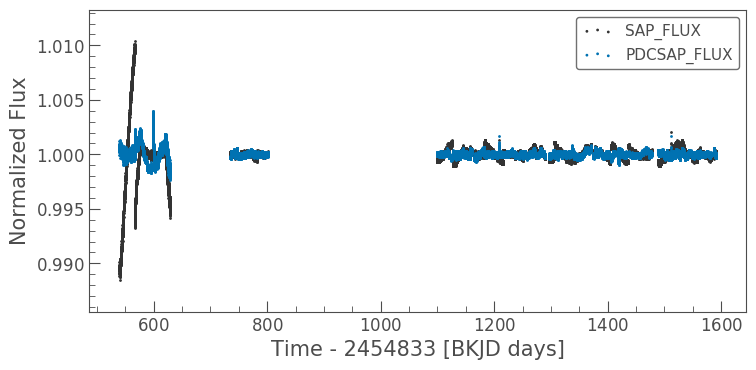

In [3]:
for name in ['KIC 11918630']:
    sr = lk.search_lightcurvefile(name, mission='Kepler', cadence='short')
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = lc1.flux#-2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [36]:
(np.array(sorted(times))-2457000)[70000:]

array([1107.16931762, 1107.1699988 , 1107.17067989, ..., 1590.97080664,
       1590.97353113, 1590.97421235])

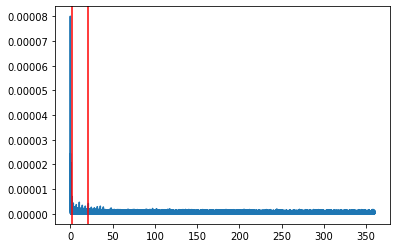

In [37]:
freq_tmp, amp_tmp, power_tmp = AS(times[70000:], mags[70000:], 10)
plt.plot(freq_tmp, amp_tmp)
#plt.xlim(120, 360)
#plt.ylim(0, 0.00001)


plt.axvline(freq_tmp[15000], c='r')
plt.axvline(freq_tmp[180000], c='r')

In [43]:
np.mean(amp_tmp[180000:])/np.sqrt(np.pi/len(times[70000:]))*1e6

138.96725023868441

In [44]:
np.median(amp_tmp[180000:])/np.sqrt(np.pi/len(times[70000:]))*1e6

130.2525253503697

In [45]:
2*rms(amp_tmp[180000:])/np.sqrt(np.pi/len(times[70000:]))*1e6

146.1070293918603

In [47]:
138.967/np.sqrt(60)

17.940562555746872

In [48]:
15/np.sqrt(1/6)

36.742346141747674

(0, 2e-07)

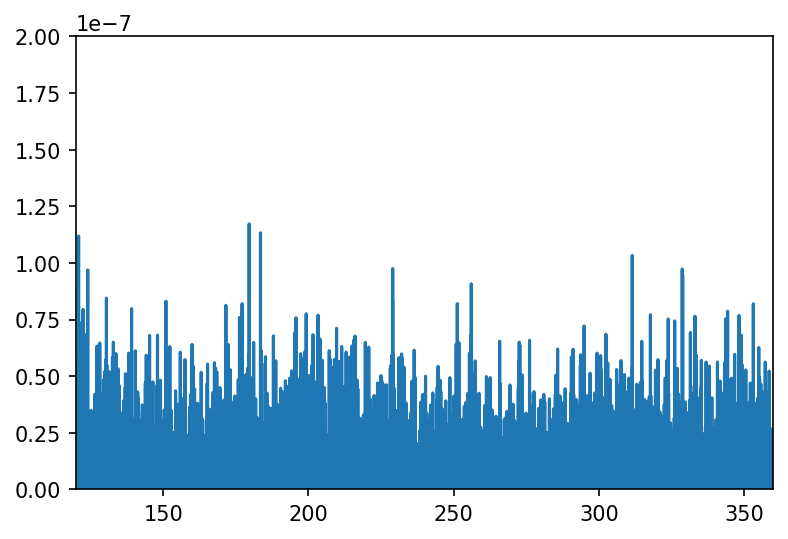

In [509]:
plt.plot(freq_tmp, power_tmp)
plt.xlim(120, 360)
plt.ylim(0, 0.0000002)

In [491]:
len(freq_tmp)
half = int(len(freq_tmp)/2)

In [492]:
freq_tmp[half:]

array([180.02136689, 180.02341156, 180.02545624, ..., 359.99570625,
       359.99775093, 359.9997956 ])

In [493]:
np.sqrt(rms(power_tmp[half:]))*1e6

106.48276514238648

In [515]:
lc1.estimate_cdpp(sigma=1)

19.173425113713446

In [374]:
rms(as_lk[1][half:])

3.287095312895065e-09

In [748]:
rms_calc1 = []
rms_calc2 = []

mean_calc1 = []
mean_calc2 = []

median_calc1 = []
median_calc2 = []

true_tmp = []

cdpp_tmp = []
noise_lk_list = []


for i in np.arange(10,20000, 300):
    #print(i)
    noise_lk = i*1e-6
    noise_lk_list.append(noise_lk)

    t_lk = np.arange(1400, 1400+27, 2/1440)

    f_lk = np.array([1]*len(t_lk))
    f_lk_sin = f_lk + 0.001*np.sin(2*np.pi*50*t_lk) + 0.001*np.sin(2*np.pi*47*t_lk) + 0.001*np.sin(2*np.pi*53*t_lk)
    #print(np.median(f_lk_sin))
    f_lk_sin = f_lk_sin + np.random.normal(0,noise_lk ,len(t_lk))
    f_lk_sin = f_lk_sin/np.median(f_lk_sin)

    as_lk = AS(t_lk, f_lk_sin, 1)
    half = int(len(as_lk[0])/2)

    lc_lk = lk.LightCurve(t_lk, f_lk_sin)

    rms_calc1.append(rms(as_lk[1][half:]))
    rms_calc2.append(rms(as_lk[2][half:]))

    mean_calc1.append(np.mean(as_lk[1][half:]))
    mean_calc2.append(np.mean(as_lk[2][half:]))
    
    median_calc1.append(np.median(as_lk[1][half:]))
    median_calc2.append(np.median(as_lk[2][half:]))
    

mean_calc1 = np.array(mean_calc1)
mean_calc2 = np.array(mean_calc2)
median_calc1 = np.array(median_calc1)
median_calc2 = np.array(median_calc2)
rms_calc1 = np.array(rms_calc1)
rms_calc2 = np.array(rms_calc2)
#cdpp_tmp = np.array(cdpp_tmp)
noise_lk_list = np.array(noise_lk_list)

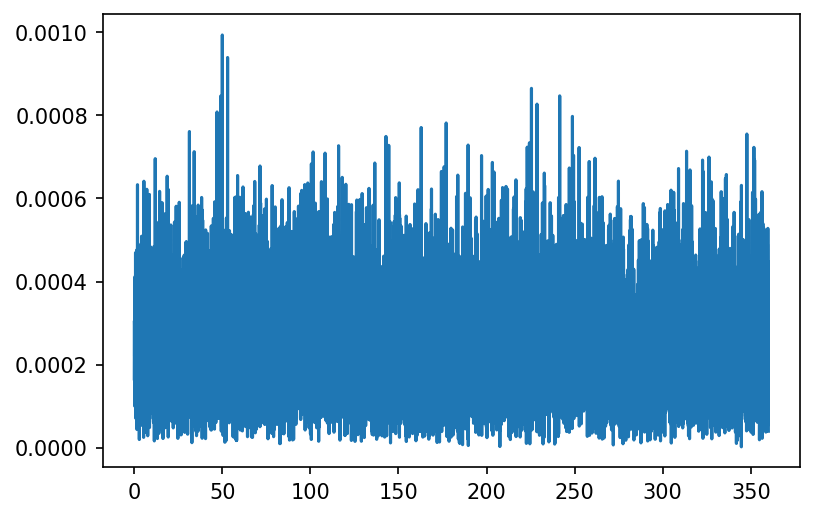

In [749]:
plt.plot(as_lk[0], as_lk[1])

(0, 19944.94283104271)

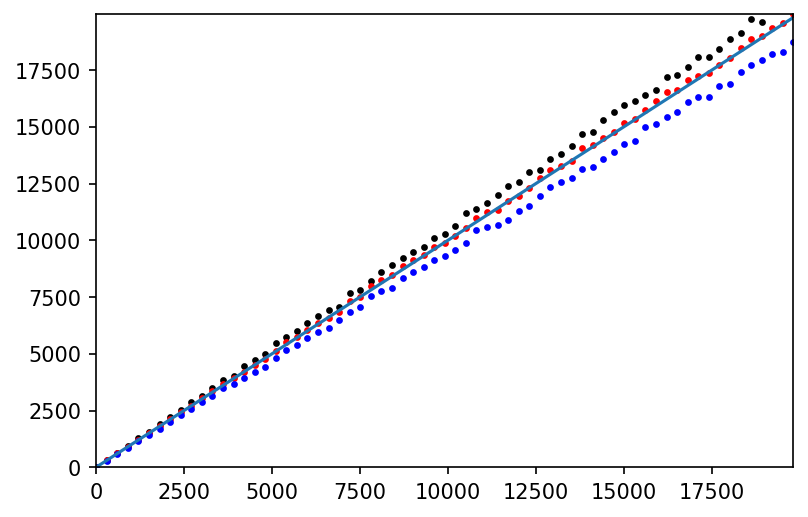

In [750]:
plt.scatter(noise_lk_list*1e6, 2*rms_calc1/np.sqrt(np.pi/len(t_lk))*1e6, s=5, c='k')
plt.scatter(noise_lk_list*1e6, mean_calc1/np.sqrt(np.pi/len(t_lk))*1e6, s=5, c='r')
plt.scatter(noise_lk_list*1e6, median_calc1/np.sqrt(np.pi/len(t_lk))*1e6, s=5, c='b')
plt.plot([0,1*1e6], [0,1*1e6])

plt.xlim(0, max(noise_lk_list)*1e6)
plt.ylim(0, max(mean_calc1/np.sqrt(np.pi/len(t_lk)))*1e6)

In [534]:
np.median(f_lk_sin)

0.9999868000614552

522.1045151389447


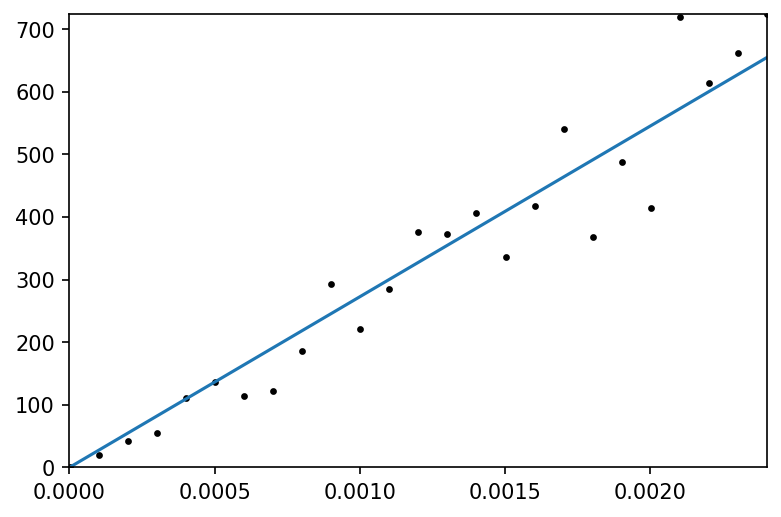

In [537]:
plt.scatter(noise_lk_list, cdpp_tmp, s=5, c='k')
#plt.plot([0,1], [0,1])

plt.xlim(0, max(noise_lk_list))
plt.ylim(0,max(cdpp_tmp))

b = lin_fit(noise_lk_list, cdpp_tmp)[0][0]
x_bla = np.linspace(0, max(noise_lk_list), 10)
y_bla = x_bla * b
plt.plot(x_bla, y_bla)

print(np.sqrt(b))

(0, 5.3987069376725464e-06)

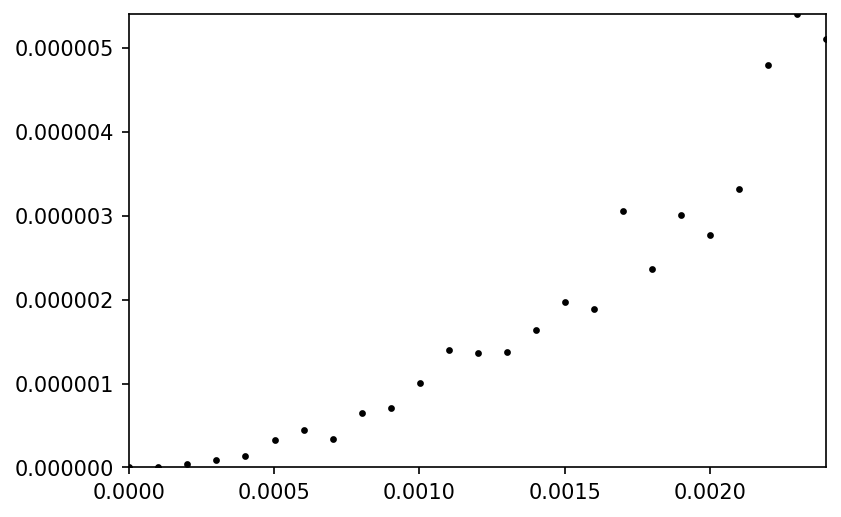

In [538]:
plt.scatter(noise_lk_list, rms_calc2, s=5, c='k')
#plt.plot([0,1], [0,1])

plt.xlim(0, max(noise_lk_list))
plt.ylim(0, max(rms_calc2))

# b = lin_fit(noise_lk_list, np.sqrt(rms_calc2))[0][0]
# x_bla = np.linspace(0, max(noise_lk_list), 10)
# y_bla = x_bla * b
# plt.plot(x_bla, y_bla)

# print(b)

0.9356073307467779


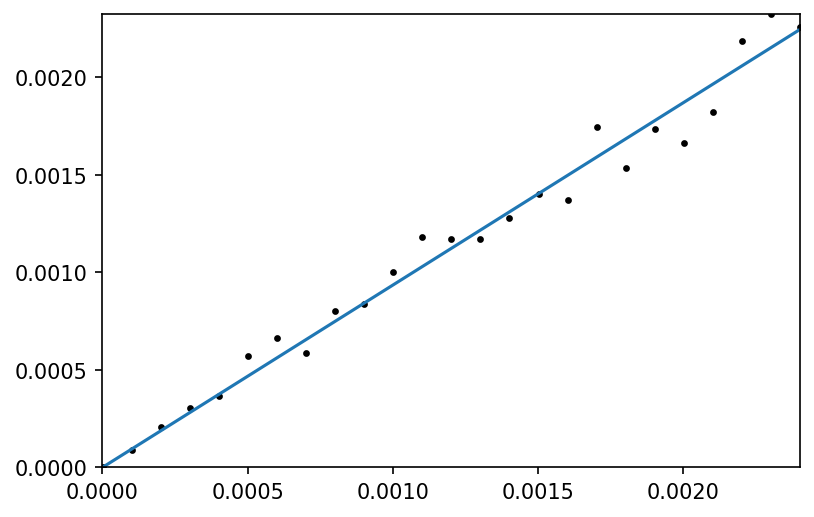

In [539]:
plt.scatter(noise_lk_list, np.sqrt(rms_calc2), s=5, c='k')
#plt.plot([0,1], [0,1])

plt.xlim(0, max(noise_lk_list))
plt.ylim(0,np.sqrt( max(rms_calc2)))

b = lin_fit(noise_lk_list, np.sqrt(rms_calc2))[0][0]
x_bla = np.linspace(0, max(noise_lk_list), 10)
y_bla = x_bla * b
plt.plot(x_bla, y_bla)

print(b)

0.08801305077920096
0.007746297107462208
0.12446925007777791
0.06223462503888895
0.010954918427544532
0.005477459213772265


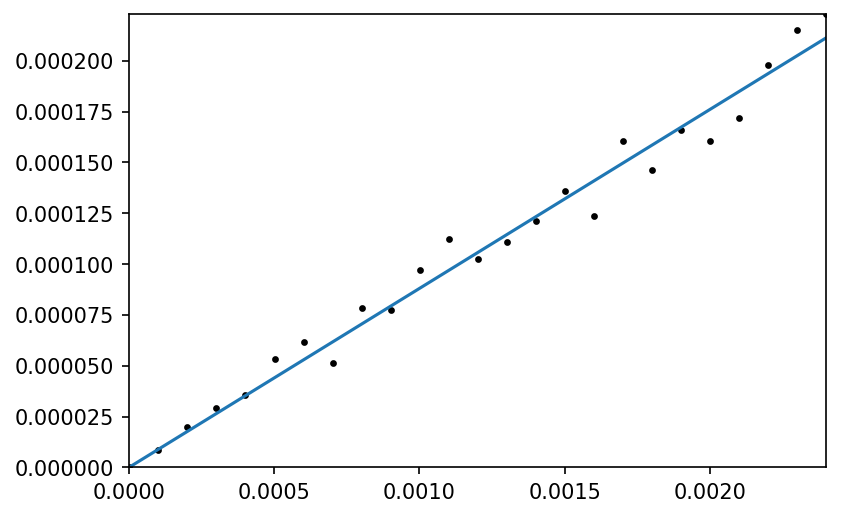

In [540]:
plt.scatter(noise_lk_list, rms_calc1, s=5, c='k')
#plt.plot([0,1], [0,1])

b = lin_fit(noise_lk_list, rms_calc1)[0][0]
x_bla = np.linspace(0, max(noise_lk_list), 10)
y_bla = x_bla * b
plt.plot(x_bla, y_bla)

plt.xlim(0, max(noise_lk_list))
plt.ylim(0, max(rms_calc1))

print(b)
print(b**2)
print(b*np.sqrt(2))
print(b/np.sqrt(2))
print(b**2*np.sqrt(2))
print(b**2/np.sqrt(2))

In [437]:
b

0.010951765329588716

In [420]:
def lin_fit(x, y):
    '''Fits a linear fit of the form mx+b to the data'''
    fitfunc = lambda params, x: params[0] * x     #create fitting function of form mx+b
    errfunc = lambda p, x, y: fitfunc(p, x) - y              #create error function for least squares fit

    init_a = 0.5                            #find initial value for a (gradient)
                             #find initial value for b (y axis intersection)
    init_p = np.array((init_a))  #bundle initial values in initial parameters

    #calculate best fitting parameters (i.e. m and b) using the error function
    p1, success = scipy.optimize.leastsq(errfunc, init_p.copy(), args = (x, y))
    f = fitfunc(p1, x)          #create a fit with those parameters
    return p1, f    

In [429]:
b

0.010960080293451701

(0, 0.0008371224120950185)

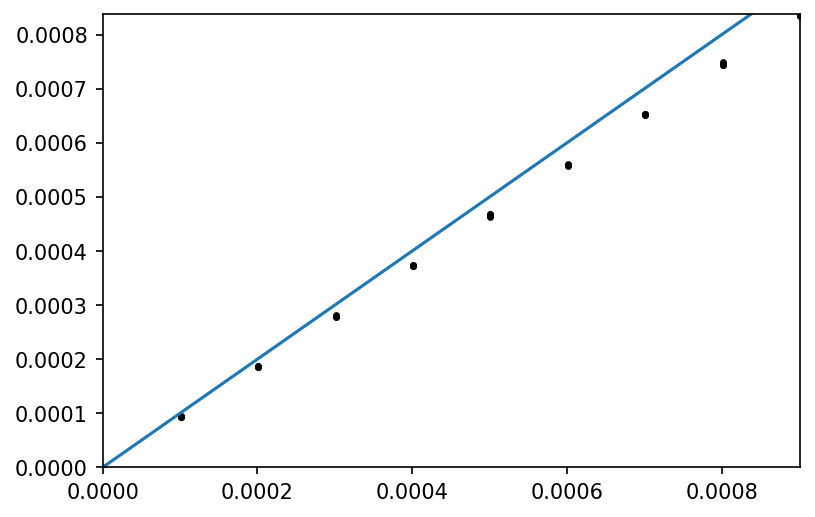

In [356]:
plt.scatter(noise_lk_list, rms_calc2, s=5, c='k')

plt.plot([0,1], [0,1])

plt.xlim(0, max(noise_lk_list))
plt.ylim(0, max(rms_calc2))